# ldaklasifikasiAndClusteringUTS
## UTS PPW
### Nama : Wahyu Rohmatul Abidin
### Nim  : 220411100198

## Tugas 1
1.	Lakukan analisa klasifikasikan berita dengan extraksi fitur model topik modelling dengan classifier naïve bayes dan SVM (data https://drive.google.com/file/d/1a776C4mmVbC-84gx_No0is9QDfpWFIme/view?usp=drive_link)

In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

### 1. Import Library yang Diperlukan

In [1]:
import pandas as pd
import numpy as np
import re
from gensim import corpora, models
from gensim.models import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk

# Download stopwords jika belum
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 2. Load dan Eksplorasi Data


In [2]:
# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Informasi Dataset:")
    print(f"Shape: {df.shape}")
    print(f"Kolom: {df.columns.tolist()}")
    print(f"\nSample data:")
    print(df.head())

    # Cek distribusi kategori
    print(f"\nDistribusi Kategori:")
    print(df['kategori'].value_counts())

    return df

# Load data
file_path = '/content/drive/MyDrive/Semester 7/PPW/UTS/BeritaUTS.csv'  # Ganti dengan path Anda
df = load_data(file_path)

Informasi Dataset:
Shape: (1500, 6)
Kolom: ['No', 'judul', 'berita', 'tanggal', 'kategori', 'link']

Sample data:
   No                                              judul  \
0   1  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...   
1   2  PT SIER Beri Penghargaan untuk 50 Tenant Terba...   
2   3  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...   
3   4  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...   
4   5  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...   

                                              berita  \
0  Menteri Koordinator (Menko) Bidang Perekonomia...   
1  Dalam rangka memeriahkan hari jadi ke-50, PT S...   
2  Wacana Presiden Prabowo Subianto akan membentu...   
3  BPJS Ketenagakerjaan dan Kementerian Agama (Ke...   
4  Pemerintah akan segera membentuk Satuan Tugas ...   

                         tanggal kategori  \
0  Minggu, 01 Des 2024 23:40 WIB  Ekonomi   
1  Minggu, 01 Des 2024 20:45 WIB  Ekonomi   
2  Minggu, 01 Des 2024 19:40 WIB  Ekonomi   
3  Mingg

### 3.Preprocessing Data

In [3]:
def preprocess_text(text):
    """Preprocessing teks untuk LDA dan klasifikasi"""
    if not isinstance(text, str):
        return ""

    # Gabungkan judul dan berita
    if isinstance(text, str):
        text = text.lower()

    # Remove tanda baca, numbers, dan special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def tokenize_text(text):
    """Tokenisasi teks untuk LDA"""
    tokens = text.split()
    # Remove stopwords Indonesia
    stop_words = set(stopwords.words('indonesian'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return tokens

# Preprocessing data
print("Preprocessing data...")
df['teks_gabungan'] = df['judul'] + ' ' + df['berita'].fillna('')
df['teks_clean'] = df['teks_gabungan'].apply(preprocess_text)
df['tokens'] = df['teks_clean'].apply(tokenize_text)

print(f"Sample setelah preprocessing:")
print(df[['judul', 'kategori', 'teks_clean']].head())

Preprocessing data...
Sample setelah preprocessing:
                                               judul kategori  \
0  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...  Ekonomi   
1  PT SIER Beri Penghargaan untuk 50 Tenant Terba...  Ekonomi   
2  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...  Ekonomi   
3  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...  Ekonomi   
4  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...  Ekonomi   

                                          teks_clean  
0  airlangga harap kenaikan ump tingkatkan daya b...  
1  pt sier beri penghargaan untuk tenant terbaik ...  
2  prabowo bakal bentuk kementerian penerimaan ne...  
3  sinergi kemenag bpjs ketenagakerjaan lindungi ...  
4  pemerintah segera bentuk satgas phk usai tetap...  


### 4. Persiapan Untuk training

In [4]:
# Split data
X = df['teks_clean']
y = df['kategori']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Kategori: {label_encoder.classes_}")
print(f"Shape X: {X.shape}, y: {y_encoded.shape}")

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Kategori: ['Ekonomi' 'Internasional' 'Nasional' 'Olahraga']
Shape X: (1500,), y: (1500,)
Train size: (1050,), Test size: (450,)


### 5. Ekstraksi Fitur dengan LDA

In [5]:
def prepare_lda_features(X_train, X_test, num_topics):
    """Mempersiapkan fitur LDA untuk training dan testing"""

    # Tokenize untuk LDA
    train_tokens = [text.split() for text in X_train]
    test_tokens = [text.split() for text in X_test]

    # Create dictionary
    dictionary = corpora.Dictionary(train_tokens)
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create corpus
    train_corpus = [dictionary.doc2bow(tokens) for tokens in train_tokens]
    test_corpus = [dictionary.doc2bow(tokens) for tokens in test_tokens]

    # Train LDA model
    lda_model = LdaModel(
        corpus=train_corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto'
    )

    # Convert documents to topic distributions
    def get_topic_distribution(corpus, lda_model, num_topics):
        features = []
        for doc in corpus:
            topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
            topic_vector = [prob for _, prob in topic_dist]
            features.append(topic_vector)
        return np.array(features)

    # Extract features
    X_train_lda = get_topic_distribution(train_corpus, lda_model, num_topics)
    X_test_lda = get_topic_distribution(test_corpus, lda_model, num_topics)

    print(f"LDA Features - Train: {X_train_lda.shape}, Test: {X_test_lda.shape}")

    return X_train_lda, X_test_lda, lda_model, dictionary

# Ekstraksi fitur LDA
print("Ekstraksi fitur dengan LDA...")
X_train_lda, X_test_lda, lda_model, dictionary = prepare_lda_features(X_train, X_test, num_topics=15)

Ekstraksi fitur dengan LDA...
LDA Features - Train: (1050, 15), Test: (450, 15)


In [67]:
X_train_lda.shape

(1050, 15)

In [68]:
X_train_lda

array([[3.08347791e-01, 1.13997165e-04, 1.92987645e-04, ...,
        1.41992918e-04, 5.86755693e-01, 1.39208161e-04],
       [2.16955916e-04, 1.62588549e-04, 9.97491837e-01, ...,
        2.02517520e-04, 1.92274689e-04, 1.98545735e-04],
       [2.81079527e-04, 2.10643309e-04, 9.96750534e-01, ...,
        2.62373709e-04, 2.49103497e-04, 2.57228035e-04],
       ...,
       [2.87380331e-04, 2.15365173e-04, 3.64594714e-04, ...,
        2.68255186e-04, 2.54687504e-04, 1.81650892e-01],
       [1.63092054e-02, 2.24162810e-04, 4.46541846e-01, ...,
        2.79213360e-04, 2.65091454e-04, 2.73737416e-04],
       [3.25672678e-04, 2.44061754e-04, 4.13176080e-04, ...,
        3.03999142e-04, 2.88623647e-04, 2.98037106e-04]], dtype=float32)

In [71]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

In [ ]:
# model_list, coherence_values = compute_coherence_values(dictionary=dictionary, texts=train_corpus, start=2, limit=40, step=6)

### 6. Training dengan naive bayes

In [7]:
def train_naive_bayes(X_train_lda, y_train):
    """Training Naive Bayes dengan kedua jenis fitur"""

    # NB dengan fitur LDA
    nb_lda = MultinomialNB()
    nb_lda.fit(X_train_lda, y_train)

    # # NB dengan fitur TF-IDF
    # nb_tfidf = MultinomialNB()
    # nb_tfidf.fit(X_train_tfidf, y_train)

    return nb_lda

print("Training Naive Bayes...")
nb_lda = train_naive_bayes(X_train_lda, y_train)

Training Naive Bayes...


### 7. Training dengan SVM

In [9]:
def train_svm(X_train_lda, y_train):
    """Training SVM dengan kedua jenis fitur"""

    # SVM dengan fitur LDA
    svm_lda = SVC(kernel='linear', random_state=42, probability=True)
    svm_lda.fit(X_train_lda, y_train)

    return svm_lda

print("Training SVM...")
svm_lda = train_svm(X_train_lda, y_train)


Training SVM...


### 8. Evaluasi Model

EVALUASI SEMUA MODEL

EVALUASI: Naive Bayes dengan LDA Features
Accuracy: 0.8978

Classification Report:
               precision    recall  f1-score   support

      Ekonomi       0.84      0.96      0.89       113
Internasional       0.92      0.90      0.91       112
     Nasional       0.86      0.75      0.80       113
     Olahraga       0.98      0.98      0.98       112

     accuracy                           0.90       450
    macro avg       0.90      0.90      0.90       450
 weighted avg       0.90      0.90      0.90       450



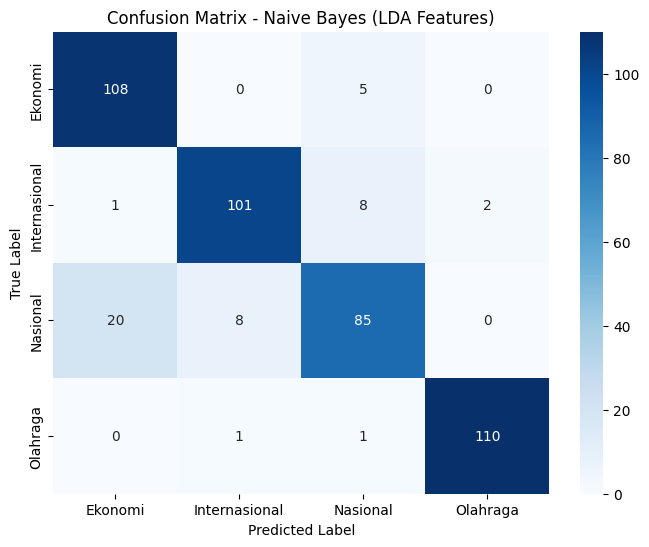


EVALUASI: SVM dengan LDA Features
Accuracy: 0.8933

Classification Report:
               precision    recall  f1-score   support

      Ekonomi       0.85      0.90      0.88       113
Internasional       0.94      0.90      0.92       112
     Nasional       0.81      0.79      0.80       113
     Olahraga       0.98      0.98      0.98       112

     accuracy                           0.89       450
    macro avg       0.89      0.89      0.89       450
 weighted avg       0.89      0.89      0.89       450



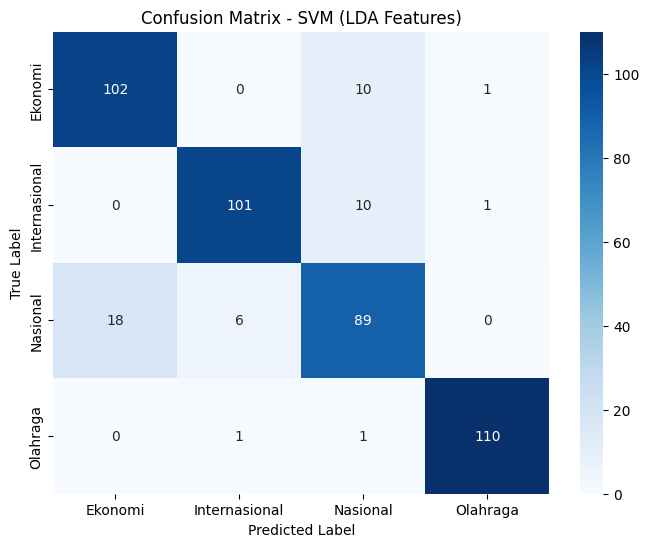

In [11]:
def evaluate_model(model, X_test, y_test, model_name, feature_type):
    """Evaluasi model dan return metrics"""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n{'='*50}")
    print(f"EVALUASI: {model_name} dengan {feature_type}")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return accuracy, y_pred

def plot_confusion_matrix(y_true, y_pred, model_name, feature_type):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name} ({feature_type})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluasi semua model
results = {}

print("EVALUASI SEMUA MODEL")
print("="*60)

# Naive Bayes dengan LDA
acc_nb_lda, y_pred_nb_lda = evaluate_model(nb_lda, X_test_lda, y_test, "Naive Bayes", "LDA Features")
results['NB_LDA'] = acc_nb_lda
plot_confusion_matrix(y_test, y_pred_nb_lda, "Naive Bayes", "LDA Features")

# Naive Bayes dengan TF-IDF
# acc_nb_tfidf, y_pred_nb_tfidf = evaluate_model(nb_tfidf, X_test_tfidf, y_test, "Naive Bayes", "TF-IDF Features")
# results['NB_TFIDF'] = acc_nb_tfidf
# plot_confusion_matrix(y_test, y_pred_nb_tfidf, "Naive Bayes", "TF-IDF Features")

# SVM dengan LDA
acc_svm_lda, y_pred_svm_lda = evaluate_model(svm_lda, X_test_lda, y_test, "SVM", "LDA Features")
results['SVM_LDA'] = acc_svm_lda
plot_confusion_matrix(y_test, y_pred_svm_lda, "SVM", "LDA Features")

# SVM dengan TF-IDF
# acc_svm_tfidf, y_pred_svm_tfidf = evaluate_model(svm_tfidf, X_test_tfidf, y_test, "SVM", "TF-IDF Features")
# results['SVM_TFIDF'] = acc_svm_tfidf
# plot_confusion_matrix(y_test, y_pred_svm_tfidf, "SVM", "TF-IDF Features")


PERBANDINGAN PERFORMAN SEMUA MODEL
     Model  Accuracy
0   NB_LDA  0.897778
1  SVM_LDA  0.893333


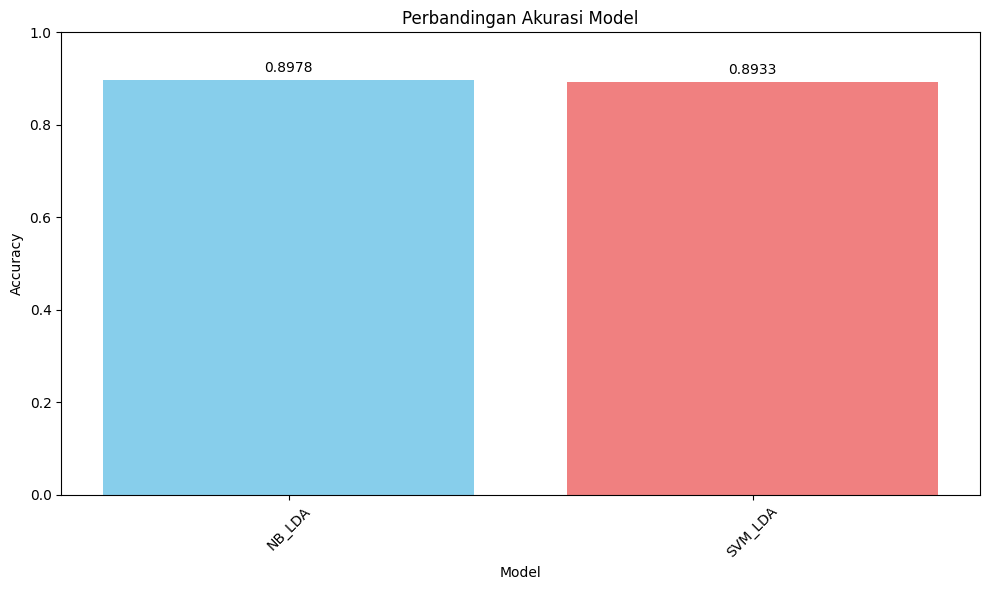

In [12]:
def compare_models(results):
    """Perbandingan performa semua model"""
    print("\n" + "="*60)
    print("PERBANDINGAN PERFORMAN SEMUA MODEL")
    print("="*60)

    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': list(results.values())
    }).sort_values('Accuracy', ascending=False)

    print(comparison_df)

    # Plot comparison
    plt.figure(figsize=(10, 6))
    models = list(results.keys())
    accuracies = list(results.values())

    bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Perbandingan Akurasi Model')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return comparison_df

# Bandingkan semua model
comparison_df = compare_models(results)

## Tugas 2


In [34]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download resources jika belum
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Data yang Anda berikan
df = pd.read_csv("/content/drive/MyDrive/Semester 7/PPW/UTS/spam.csv", encoding='latin1')
df = df.iloc[:, :2]  # Ambil 2 kolom pertama
print(df.head())




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


   id                                               Text
0   1  Go until jurong point, crazy.. Available only ...
1   2                      Ok lar... Joking wif u oni...
2   3  Free entry in 2 a wkly comp to win FA Cup fina...
3   4  U dun say so early hor... U c already then say...
4   5  Nah I don't think he goes to usf, he lives aro...


In [48]:
texts = df['Text']
print(texts.head())


0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: Text, dtype: object


### 1. Preprocessing data

In [49]:
def preprocess_email(text):
    """Preprocessing khusus untuk data email"""
    if not isinstance(text, str):
        return ""

    # Case folding
    text = text.lower()

    # Remove special characters, numbers, but keep basic punctuation
    text = re.sub(r'[^\w\s\.\?\!]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def advanced_preprocessing(text):
    """Preprocessing lebih mendalam untuk clustering"""
    # Basic cleaning
    text = preprocess_email(text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)

# Preprocessing data
emails = [preprocess_email(email) for email in texts if isinstance(email, str)]
advanced_emails = [advanced_preprocessing(email) for email in texts if isinstance(email, str)]

print("Sample setelah preprocessing:")
for i in range(3):
    print(f"Original: {texts[i][:50]}...")
    print(f"Cleaned: {emails[i][:50]}...")
    print(f"Advanced: {advanced_emails[i][:50]}...")
    print("-" * 50)

Sample setelah preprocessing:
Original: Go until jurong point, crazy.. Available only in b...
Cleaned: go until jurong point crazy.. available only in bu...
Advanced: jurong point crazi avail bugi great world buffet ....
--------------------------------------------------
Original: Ok lar... Joking wif u oni......
Cleaned: ok lar... joking wif u oni......
Advanced: lar ... joke wif oni ......
--------------------------------------------------
Original: Free entry in 2 a wkly comp to win FA Cup final tk...
Cleaned: free entry in a wkly comp to win fa cup final tkts...
Advanced: free entri wkli comp win cup final tkt may text re...
--------------------------------------------------


### 2. Eksplorasi Data

=== EKSPLORASI DATA ===
Total emails: 5572
Average words per email: 15.7
Total unique words: 10858
Most common words: [('i', 2896), ('to', 2229), ('you', 2062), ('a', 1441), ('the', 1329), ('u', 1074), ('and', 972), ('in', 877), ('is', 875), ('my', 755)]


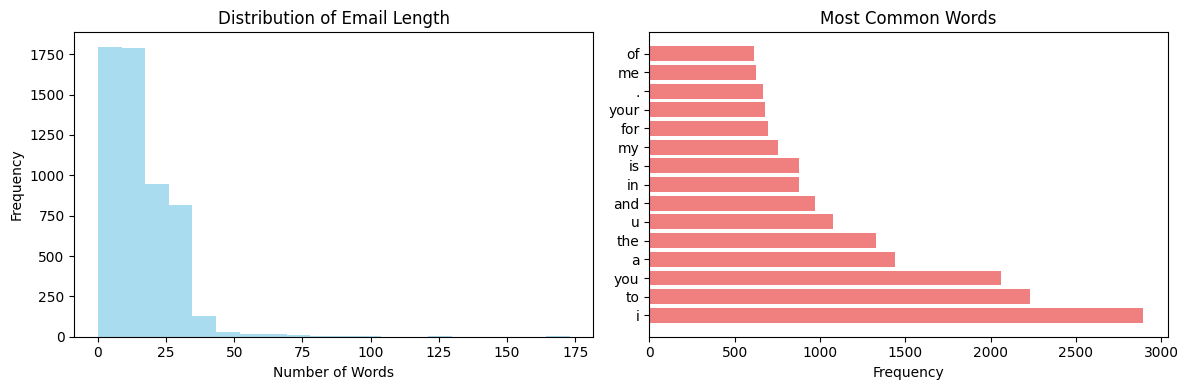

In [50]:
def explore_data(emails):
    """Eksplorasi karakteristik data"""
    # Panjang teks
    text_lengths = [len(email.split()) for email in emails]

    # Kata unik
    all_words = ' '.join(emails).split()
    word_freq = Counter(all_words)

    print("=== EKSPLORASI DATA ===")
    print(f"Total emails: {len(emails)}")
    print(f"Average words per email: {np.mean(text_lengths):.1f}")
    print(f"Total unique words: {len(word_freq)}")
    print(f"Most common words: {word_freq.most_common(10)}")

    # Visualisasi distribusi panjang teks
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(text_lengths, bins=20, alpha=0.7, color='skyblue')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title('Distribution of Email Length')

    plt.subplot(1, 2, 2)
    common_words = word_freq.most_common(15)
    words, counts = zip(*common_words)
    plt.barh(words, counts, color='lightcoral')
    plt.xlabel('Frequency')
    plt.title('Most Common Words')

    plt.tight_layout()
    plt.show()

    return text_lengths, word_freq

# Eksplorasi data
text_lengths, word_freq = explore_data(emails)

### 3. Ekstraksi Fitur dengan TF-IDF


In [52]:
def extract_features(emails, max_features):
    """Ekstraksi fitur menggunakan TF-IDF"""

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        min_df=2,  # Ignore terms that appear in less than 2 documents
        max_df=0.8,  # Ignore terms that appear in more than 80% of documents
        ngram_range=(1, 2)  # Use unigrams and bigrams
    )

    # Fit and transform
    tfidf_matrix = tfidf_vectorizer.fit_transform(emails)

    print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
    print(f"Feature names sample: {tfidf_vectorizer.get_feature_names_out()[:10]}")

    return tfidf_matrix, tfidf_vectorizer

# Ekstraksi fitur
tfidf_matrix, vectorizer = extract_features(emails,max_features=100)

TF-IDF Matrix Shape: (5572, 100)
Feature names sample: ['amp' 'ask' 'babe' 'box' 'buy' 'care' 'cash' 'claim' 'com' 'come']


In [53]:
def extract_features(emails, max_features=1000):
    """Ekstraksi fitur menggunakan TF-IDF"""

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        min_df=2,  # Ignore terms that appear in less than 2 documents
        max_df=0.8,  # Ignore terms that appear in more than 80% of documents
        ngram_range=(1, 2)  # Use unigrams and bigrams
    )

    # Fit and transform
    tfidf_matrix = tfidf_vectorizer.fit_transform(emails)

    print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
    print(f"Feature names sample: {tfidf_vectorizer.get_feature_names_out()[:10]}")

    return tfidf_matrix, tfidf_vectorizer

# Ekstraksi fitur
tfidf_matrix, vectorizer = extract_features(emails)

TF-IDF Matrix Shape: (5572, 1000)
Feature names sample: ['abiola' 'able' 'abt' 'ac' 'account' 'account statement' 'actually'
 'address' 'admirer' 'aft']


### 4. Menentukan Jumlah Cluster Optimal

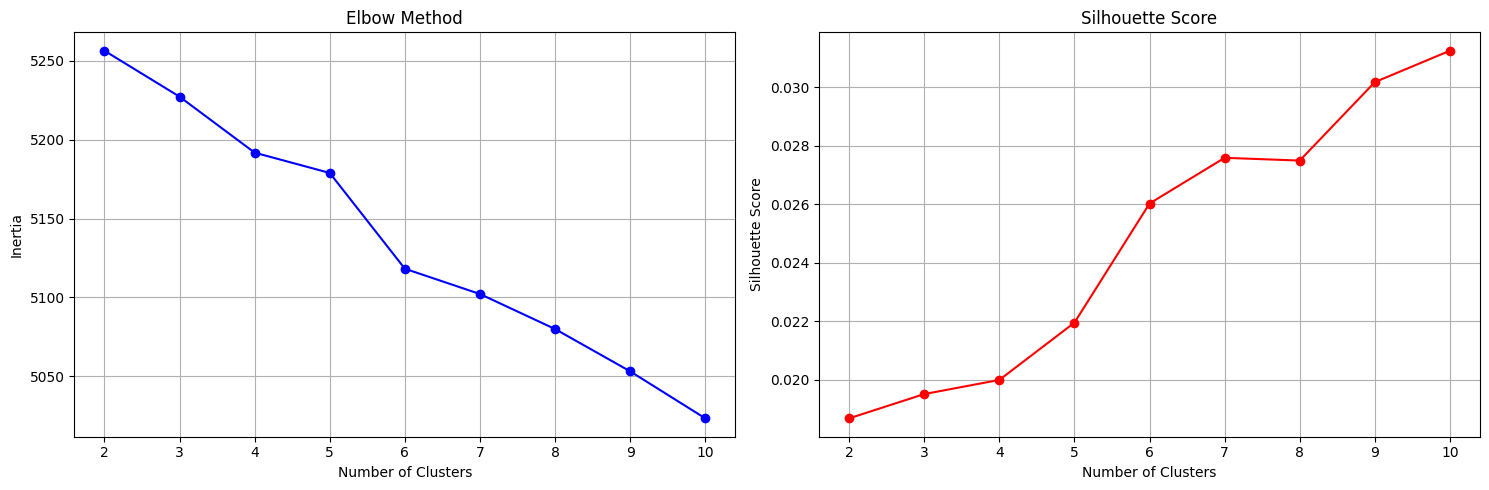

Optimal number of clusters (based on silhouette): 10


In [54]:
def find_optimal_clusters(tfidf_matrix, max_k=10):
    """Menentukan jumlah cluster optimal menggunakan elbow method dan silhouette score"""

    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        # KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)

        # Calculate metrics
        inertias.append(kmeans.inertia_)

        # Silhouette score (hitung jika lebih dari 1 cluster dan tidak semua data di satu cluster)
        if len(set(cluster_labels)) > 1:
            silhouette_scores.append(silhouette_score(tfidf_matrix, cluster_labels))
        else:
            silhouette_scores.append(0)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Elbow curve
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.grid(True)

    # Silhouette scores
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Find optimal k
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters (based on silhouette): {optimal_k}")

    return optimal_k, inertias, silhouette_scores

# Cari jumlah cluster optimal
optimal_k, inertias, silhouette_scores = find_optimal_clusters(tfidf_matrix)

### 5. Clustering dengan beberapa algoritma

In [55]:
def perform_clustering(tfidf_matrix, n_clusters=4):
    """Melakukan clustering dengan berbagai algoritma"""

    results = {}

    # Convert to dense array for algorithms that don't support sparse matrix
    X_dense = tfidf_matrix.toarray()

    # 1. KMeans
    print("Running KMeans clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(tfidf_matrix)
    results['KMeans'] = kmeans_labels

    # 2. Hierarchical Clustering
    print("Running Hierarchical clustering...")
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X_dense)
    results['Hierarchical'] = hierarchical_labels

    # 3. DBSCAN
    print("Running DBSCAN clustering...")
    dbscan = DBSCAN(eps=0.5, min_samples=2)
    dbscan_labels = dbscan.fit_predict(X_dense)
    results['DBSCAN'] = dbscan_labels

    return results

# Lakukan clustering dengan berbagai algoritma
clustering_results = perform_clustering(tfidf_matrix, n_clusters=optimal_k)

Running KMeans clustering...
Running Hierarchical clustering...
Running DBSCAN clustering...


6. Evaluasi Clustering

In [56]:
def evaluate_clustering(tfidf_matrix, clustering_results):
    """Evaluasi hasil clustering"""

    evaluation = {}
    X_dense = tfidf_matrix.toarray()

    for method, labels in clustering_results.items():
        # Skip evaluation if only one cluster or too many noise points
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in labels else 0)

        if n_clusters > 1 and len(unique_labels) < len(labels) // 2:
            try:
                silhouette = silhouette_score(tfidf_matrix, labels)
                calinski = calinski_harabasz_score(X_dense, labels)
            except:
                silhouette = -1
                calinski = -1
        else:
            silhouette = -1
            calinski = -1

        # Count cluster distribution
        cluster_counts = Counter(labels)

        evaluation[method] = {
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski,
            'n_clusters': n_clusters,
            'cluster_distribution': cluster_counts
        }

    # Print evaluation results
    print("=== CLUSTERING EVALUATION ===")
    for method, metrics in evaluation.items():
        print(f"\n{method}:")
        print(f"  Silhouette Score: {metrics['silhouette_score']:.3f}")
        print(f"  Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.3f}")
        print(f"  Number of Clusters: {metrics['n_clusters']}")
        print(f"  Cluster Distribution: {dict(metrics['cluster_distribution'])}")

    return evaluation

# Evaluasi clustering
evaluation_results = evaluate_clustering(tfidf_matrix, clustering_results)

=== CLUSTERING EVALUATION ===

KMeans:
  Silhouette Score: 0.031
  Calinski-Harabasz Score: 36.797
  Number of Clusters: 10
  Cluster Distribution: {2: 3535, 0: 199, 3: 585, 9: 165, 5: 159, 6: 193, 1: 218, 7: 138, 8: 202, 4: 178}

Hierarchical:
  Silhouette Score: 0.011
  Calinski-Harabasz Score: 26.422
  Number of Clusters: 10
  Cluster Distribution: {2: 3970, 1: 756, 6: 107, 8: 58, 3: 383, 9: 156, 5: 41, 0: 38, 4: 45, 7: 18}

DBSCAN:
  Silhouette Score: 0.036
  Calinski-Harabasz Score: 3.774
  Number of Clusters: 489
  Cluster Distribution: {-1: 3930, 0: 2, 1: 2, 2: 5, 3: 2, 4: 2, 5: 2, 6: 2, 7: 3, 8: 4, 9: 8, 10: 3, 11: 5, 12: 3, 13: 39, 14: 10, 15: 3, 16: 3, 17: 2, 18: 2, 19: 5, 20: 194, 21: 2, 22: 3, 23: 2, 24: 2, 25: 10, 26: 2, 27: 5, 28: 3, 29: 4, 30: 3, 31: 4, 32: 3, 33: 8, 34: 4, 35: 2, 36: 5, 37: 2, 38: 2, 39: 3, 40: 5, 41: 2, 42: 6, 43: 3, 44: 2, 45: 2, 46: 4, 47: 3, 48: 11, 49: 2, 50: 29, 51: 2, 52: 2, 53: 2, 54: 2, 55: 3, 56: 2, 57: 2, 58: 3, 59: 8, 60: 3, 61: 3, 62: 2, 63

### 7. Visualisasi hasil clustering

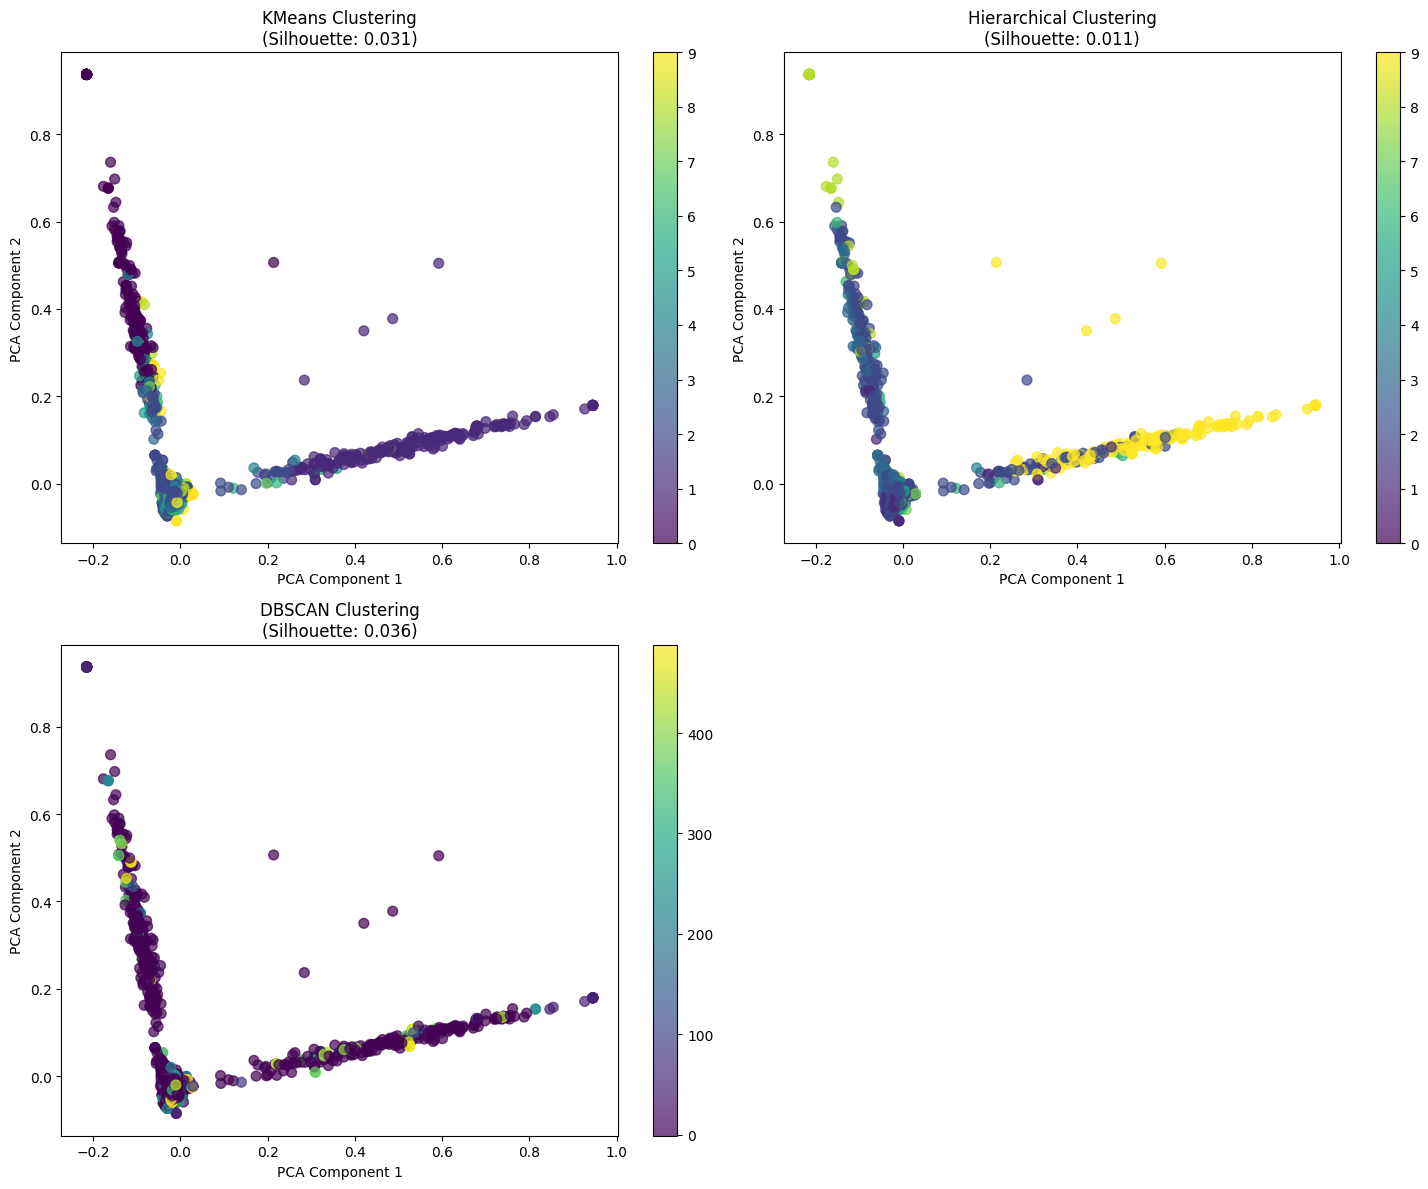

In [57]:
def visualize_clusters(tfidf_matrix, clustering_results, emails):
    """Visualisasi hasil clustering dengan PCA"""

    # Reduce dimensions untuk visualisasi
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(tfidf_matrix.toarray())

    # Plot untuk setiap metode clustering
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    methods = list(clustering_results.keys())

    for i, method in enumerate(methods):
        labels = clustering_results[method]

        scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1],
                                 c=labels, cmap='viridis', alpha=0.7, s=50)
        axes[i].set_title(f'{method} Clustering\n(Silhouette: {evaluation_results[method]["silhouette_score"]:.3f})')
        axes[i].set_xlabel('PCA Component 1')
        axes[i].set_ylabel('PCA Component 2')
        plt.colorbar(scatter, ax=axes[i])

    # Hide unused subplots
    for i in range(len(methods), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    return X_pca

# Visualisasi hasil
X_pca = visualize_clusters(tfidf_matrix, clustering_results, emails)

### 8. Analisis Cluster dengan KMeans


In [58]:
def analyze_clusters_kmeans(tfidf_matrix, vectorizer, emails, n_clusters=4):
    """Analisis mendalam cluster menggunakan KMeans"""

    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(tfidf_matrix)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    print("=== ANALISIS CLUSTER KMEANS ===")

    # Analisis setiap cluster
    for cluster_id in range(n_clusters):
        # Get indices of documents in this cluster
        cluster_indices = np.where(kmeans_labels == cluster_id)[0]

        print(f"\n📊 CLUSTER {cluster_id}:")
        print(f"   Jumlah dokumen: {len(cluster_indices)}")
        print(f"   Persentase: {len(cluster_indices)/len(emails)*100:.1f}%")

        # Get top terms for this cluster
        cluster_tfidf = tfidf_matrix[cluster_indices]
        cluster_tfidf_sum = np.asarray(cluster_tfidf.sum(axis=0)).flatten()
        top_term_indices = cluster_tfidf_sum.argsort()[-10:][::-1]
        top_terms = [feature_names[i] for i in top_term_indices]

        print(f"   Top 10 Terms: {', '.join(top_terms)}")

        # Show sample documents
        print(f"   Sample Documents:")
        for i, idx in enumerate(cluster_indices[:3]):  # Show first 3 documents
            sample_text = emails[idx][:100] + "..." if len(emails[idx]) > 100 else emails[idx]
            print(f"     {i+1}. {sample_text}")

    return kmeans_labels

# Analisis cluster dengan KMeans
kmeans_labels = analyze_clusters_kmeans(tfidf_matrix, vectorizer, emails, n_clusters=optimal_k)

=== ANALISIS CLUSTER KMEANS ===

📊 CLUSTER 0:
   Jumlah dokumen: 199
   Persentase: 3.6%
   Top 10 Terms: ok, ok lor, lor, thanx, ur, leave, said, yup, time, ask
   Sample Documents:
     1. ok lar... joking wif u oni...
     2. yup... ok i go home look at the timings then i msg ì_ again... xuhui going to learn on nd may too bu...
     3. ok i am on the way to home hi hi

📊 CLUSTER 1:
   Jumlah dokumen: 218
   Persentase: 3.9%
   Top 10 Terms: gt, lt, lt gt, gt min, lt decimal, decimal gt, decimal, like lt, like, ll
   Sample Documents:
     1. great! i hope you like your man well endowed. i am lt gt inches...
     2. a gram usually runs like lt gt a half eighth is smarter though and gets you almost a whole second gr...
     3. do you know what mallika sherawat did yesterday? find out now lt url gt

📊 CLUSTER 2:
   Jumlah dokumen: 3535
   Persentase: 63.4%
   Top 10 Terms: just, got, going, good, da, time, home, lor, want, day
   Sample Documents:
     1. go until jurong point crazy.. 

### 9. Interpretasi Cluster


In [59]:
def interpret_clusters(kmeans_labels, emails, tfidf_matrix, vectorizer):
    """Interpretasi dan penamaan cluster berdasarkan konten"""

    feature_names = vectorizer.get_feature_names_out()
    n_clusters = len(set(kmeans_labels))

    cluster_interpretation = {}

    print("\n=== INTERPRETASI CLUSTER ===")

    for cluster_id in range(n_clusters):
        cluster_indices = np.where(kmeans_labels == cluster_id)[0]

        # Analyze content
        cluster_docs = [emails[i] for i in cluster_indices]
        cluster_tfidf = tfidf_matrix[cluster_indices]

        # Get distinctive terms
        cluster_tfidf_sum = np.asarray(cluster_tfidf.sum(axis=0)).flatten()
        overall_tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

        # Calculate term distinctiveness (TF-IDF ratio)
        term_ratio = cluster_tfidf_sum / (overall_tfidf_sum + 1e-6)
        distinctive_terms_indices = term_ratio.argsort()[-8:][::-1]
        distinctive_terms = [feature_names[i] for i in distinctive_terms_indices]

        # Determine cluster type based on terms and content
        cluster_terms_str = ' '.join(cluster_docs).lower()

        # Simple rule-based classification
        if any(term in cluster_terms_str for term in ['free', 'win', 'prize', 'cash', 'reward']):
            cluster_type = "Promotional/Spam"
        elif any(term in cluster_terms_str for term in ['call', 'text', 'message', 'mobile']):
            cluster_type = "Communication"
        elif any(term in cluster_terms_str for term in ['love', 'miss', 'dear', 'baby']):
            cluster_type = "Personal/Relationship"
        elif any(term in cluster_terms_str for term in ['ok', 'yes', 'no', 'sorry']):
            cluster_type = "Casual Conversation"
        else:
            cluster_type = "General/Miscellaneous"

        cluster_interpretation[cluster_id] = {
            'type': cluster_type,
            'distinctive_terms': distinctive_terms,
            'size': len(cluster_indices),
            'sample_docs': cluster_docs[:2]  # First 2 documents as samples
        }

        print(f"\n🎯 Cluster {cluster_id}: {cluster_type}")
        print(f"   Distinctive Terms: {', '.join(distinctive_terms)}")
        print(f"   Size: {len(cluster_indices)} documents")

    return cluster_interpretation

# Interpretasi cluster
cluster_interpretation = interpret_clusters(kmeans_labels, emails, tfidf_matrix, vectorizer)


=== INTERPRETASI CLUSTER ===

🎯 Cluster 0: Promotional/Spam
   Distinctive Terms: ok lor, ok, prob, thanx, treat, askd, todays, lor
   Size: 199 documents

🎯 Cluster 1: Promotional/Spam
   Distinctive Terms: gt min, gt lt, lt gt, like lt, lt, gt, lt decimal, decimal gt
   Size: 218 documents

🎯 Cluster 2: Promotional/Spam
   Distinctive Terms: okie, sunday, gotta, sae, wasn, wana, await collection, prize claim
   Size: 3535 documents

🎯 Cluster 3: Promotional/Spam
   Distinctive Terms: vouchers, txt word, free text, txt stop, free entry, txts, right pls, phone right
   Size: 585 documents

🎯 Cluster 4: Promotional/Spam
   Distinctive Terms: come tomorrow, want come, come, come home, search, gal, il, dreams
   Size: 178 documents

🎯 Cluster 5: Promotional/Spam
   Distinctive Terms: goes day, love, good afternoon, goes, sea, crave, clean, wonder
   Size: 159 documents

🎯 Cluster 6: Promotional/Spam
   Distinctive Terms: dont know, don know, let know, know, dating service, dating, let, s

### 10. Visualisasi Akhir dengan Interpretasi

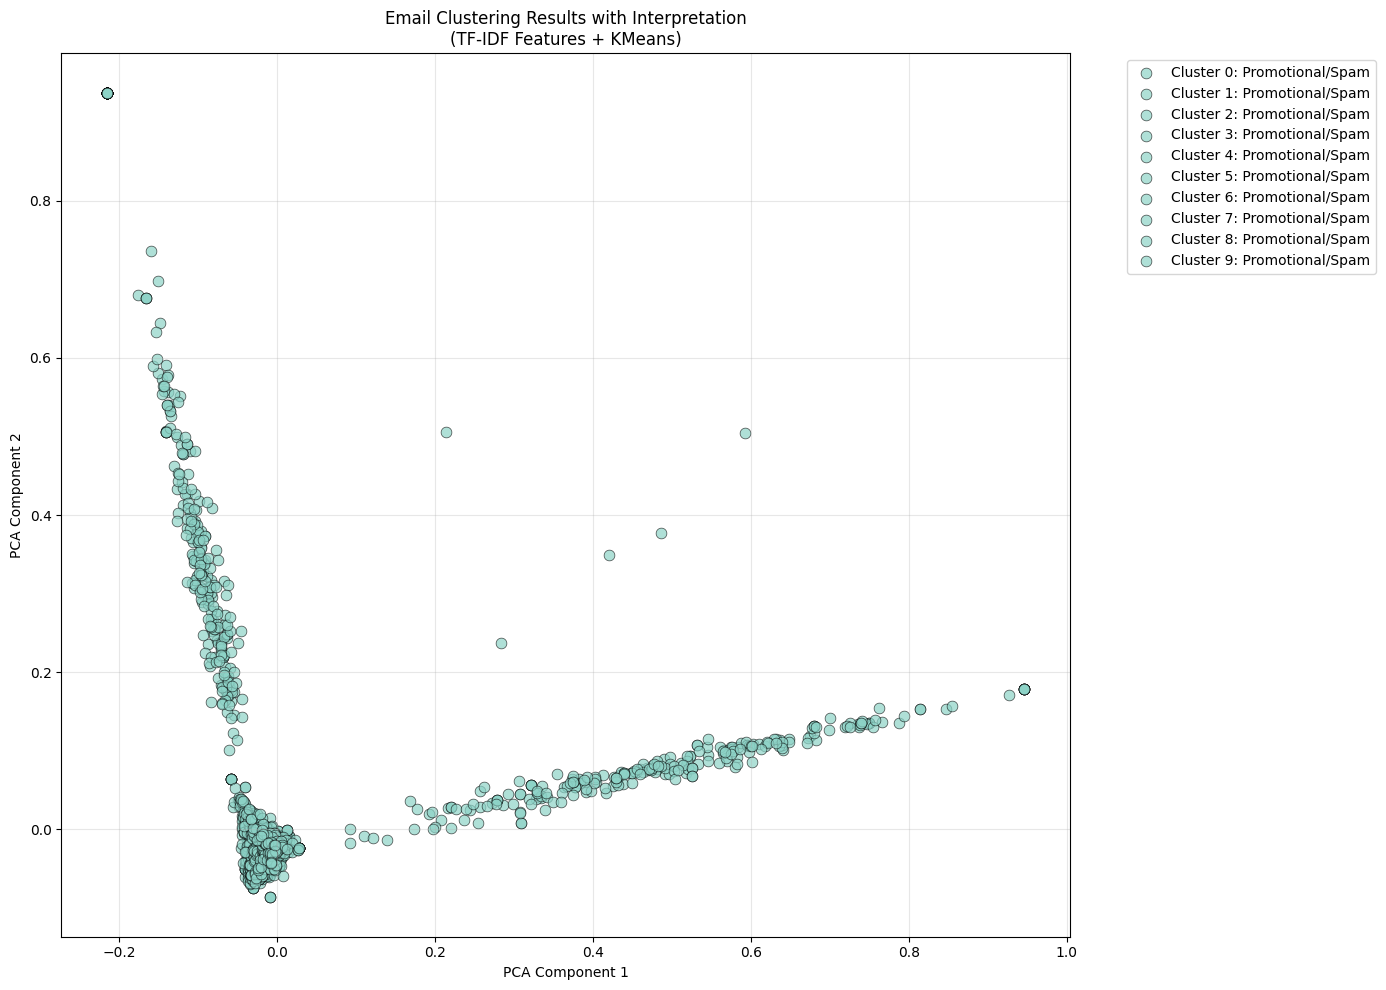

In [60]:
def final_visualization(X_pca, kmeans_labels, cluster_interpretation):
    """Visualisasi akhir dengan interpretasi cluster"""

    plt.figure(figsize=(14, 10))

    # Create color map based on cluster types
    cluster_types = [cluster_interpretation[i]['type'] for i in range(len(cluster_interpretation))]
    unique_types = list(set(cluster_types))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))

    color_map = {}
    for i, cluster_type in enumerate(unique_types):
        color_map[cluster_type] = colors[i]

    # Plot each cluster with its interpretation
    for cluster_id in range(len(cluster_interpretation)):
        cluster_indices = np.where(kmeans_labels == cluster_id)[0]
        cluster_type = cluster_interpretation[cluster_id]['type']

        plt.scatter(X_pca[cluster_indices, 0], X_pca[cluster_indices, 1],
                   c=[color_map[cluster_type]],
                   label=f'Cluster {cluster_id}: {cluster_type}',
                   alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Email Clustering Results with Interpretation\n(TF-IDF Features + KMeans)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualisasi akhir
final_visualization(X_pca, kmeans_labels, cluster_interpretation)